In [1]:
import numpy as np
from copy import copy
from six import iteritems
from matplotlib import pyplot as plt
from pygenn import genn_model, genn_wrapper

In [2]:
# Load MNIST data (pre-normalized and coverted to numpy format)
testing_images = np.load("testing_images.npy")
testing_labels = np.load("testing_labels.npy")

### Visualize training data

(10000, 784)


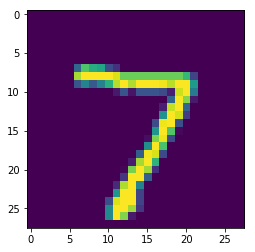

In [3]:
print(testing_images.shape)
assert np.allclose(np.sum(testing_images, axis=1), 1.0)

fig, axis = plt.subplots()
axis.imshow(np.reshape(testing_images[0], (28, 28)))

### Parameters

In [4]:
DT = 0.1
INPUT_SCALE = 80.0
NUM_PN = 784
NUM_MBON = 10
NUM_KC = 20000
PRESENT_TIME_MS = 20.0

# Standard LIF neurons parameters
LIF_PARAMS = {
    "C": 0.2,
    "TauM": 20.0,
    "Vrest": -60.0,
    "Vreset": -60.0,
    "Vthresh": -50.0,
    "Ioffset": 0.0,
    "TauRefrac": 2.0}

# We only want PNs to spike once
PN_PARAMS = copy(LIF_PARAMS)
PN_PARAMS["TauRefrac"] = 100.0

# We will use weights of 1.0 for KC->GGN connections and  
# want the GGN to inhibit the KCs after 200 spikes
GGN_PARAMS = {
    "Vthresh": 200.0}

PN_KC_WEIGHT = 0.2
PN_KC_TAU_SYN = 3.0
PN_KC_FAN_IN = 20

KC_MBON_TAU_SYN = 3.0

### Custom models

In [5]:
# Current source model, allowing current to be injected into neuron from variable
cs_model = genn_model.create_custom_current_source_class(
    "cs_model",
    var_name_types=[("magnitude", "scalar")],
    injection_code="$(injectCurrent, $(magnitude));")

# Minimal integrate and fire neuron model
if_model = genn_model.create_custom_neuron_class(
    "IF",
    param_names=["Vthresh"],
    var_name_types=[("V", "scalar")],
    sim_code=
    """
    $(V)+= $(Isyn);
    """,
    threshold_condition_code=
    """
    $(V) >= $(Vthresh)
    """,
    reset_code=
    """
    $(V)= 0.0;
    """)

### Model definition

In [6]:
# Create model
model = genn_model.GeNNModel("float", "mnist_mb_testing")
model.dT = DT
model._model.set_seed(1337)

# Create neuron populations
lif_init = {"V": PN_PARAMS["Vreset"], "RefracTime": 0.0}
if_init = {"V": 0.0}
pn = model.add_neuron_population("pn", NUM_PN, "LIF", PN_PARAMS, lif_init)
kc = model.add_neuron_population("kc", NUM_KC, "LIF", LIF_PARAMS, lif_init)
ggn = model.add_neuron_population("ggn", 1, if_model, GGN_PARAMS, if_init)
mbon = model.add_neuron_population("mbon", NUM_MBON, "LIF", LIF_PARAMS, lif_init)

# Turn on spike recording
pn.spike_recording_enabled = True
kc.spike_recording_enabled = True
mbon.spike_recording_enabled = True

# Create current sources to deliver input and supervision to network
pn_input = model.add_current_source("pn_input", cs_model, pn , {}, {"magnitude": 0.0})
mbon_input = model.add_current_source("mbon_input", cs_model, mbon , {}, {"magnitude": 0.0})

# Create synapse populations
pn_kc = model.add_synapse_population("pn_kc", "SPARSE_GLOBALG", genn_wrapper.NO_DELAY,
                                     pn, kc,
                                     "StaticPulse", {}, {"g": PN_KC_WEIGHT}, {}, {},
                                     "ExpCurr", {"tau": PN_KC_TAU_SYN}, {},
                                     genn_model.init_connectivity("FixedNumberPreWithReplacement", {"colLength": PN_KC_FAN_IN}))

kc_ggn = model.add_synapse_population("kc_ggn", "DENSE_GLOBALG", genn_wrapper.NO_DELAY, 
                                      kc, ggn, 
                                      "StaticPulse", {}, {"g": 1.0}, {}, {}, 
                                      "DeltaCurr", {}, {})

ggn_kc = model.add_synapse_population("ggn_kc", "DENSE_GLOBALG", genn_wrapper.NO_DELAY, 
                                      ggn, kc,
                                      "StaticPulse", {}, {"g": -5.0}, {}, {}, 
                                      "ExpCurr", {"tau": 5.0}, {})

kc_mbon = model.add_synapse_population("kc_mbon", "DENSE_INDIVIDUALG", genn_wrapper.NO_DELAY,
                                       kc, mbon,
                                       "StaticPulse", {}, {"g": np.load("kc_mbon.npy")}, {}, {},
                                       "ExpCurr", {"tau": KC_MBON_TAU_SYN}, {})

### Build model

In [7]:
# Convert present time into timesteps
present_timesteps = int(round(PRESENT_TIME_MS / DT))

# Build model and load it
model.build()
model.load(num_recording_timesteps=present_timesteps)

### Simulation

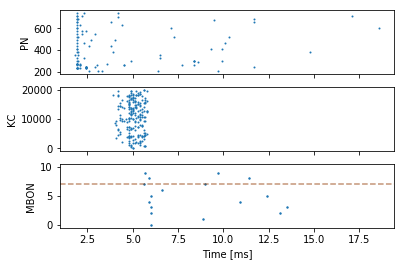

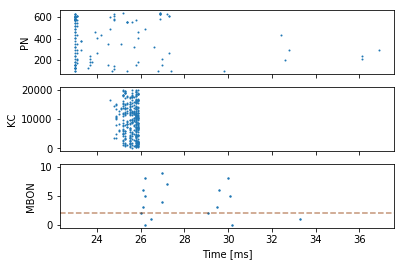

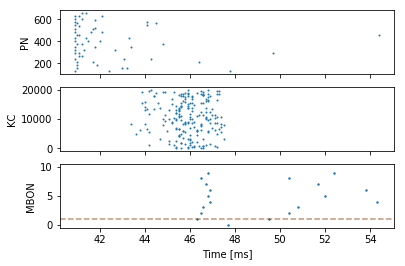

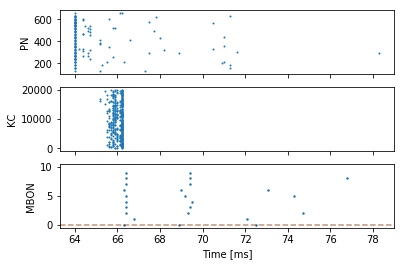

In [8]:
def reset_neuron(pop, var_init):
    # Reset variables
    for var_name, var_val in iteritems(var_init):
        pop.vars[var_name].view[:] = var_val
    
    # Push the state to GPU
    pop.push_state_to_device()

def reset_in_syn(pop):
    pop.in_syn[:] = 0.0
    pop.push_in_syn_to_device()

for s in range(4):
    # Set training image
    pn_input.vars["magnitude"].view[:] = testing_images[s] * INPUT_SCALE
    pn_input.push_var_to_device("magnitude")
    
    # Simulate present timesteps
    for i in range(present_timesteps):
        model.step_time()
    
    # Reset neuron state for next stimuli
    reset_neuron(pn, lif_init)
    reset_neuron(kc, lif_init)
    reset_neuron(ggn, if_init)
    reset_neuron(mbon, lif_init)

    # Reset synapse state
    reset_in_syn(pn_kc)
    reset_in_syn(ggn_kc)
    
    # Download spikes from GPU
    model.pull_recording_buffers_from_device();
    
    # Plot PN, KC and MBON spikes
    fig, axes = plt.subplots(3, sharex=True)
    pn_spike_times, pn_spike_ids = pn.spike_recording_data
    kc_spike_times, kc_spike_ids = kc.spike_recording_data
    mbon_spike_times, mbon_spike_ids = mbon.spike_recording_data
    
    
    axes[0].scatter(pn_spike_times, pn_spike_ids, s=1)
    axes[0].set_ylabel("PN")
    axes[1].scatter(kc_spike_times, kc_spike_ids, s=1)
    axes[1].set_ylabel("KC")
    axes[2].scatter(mbon_spike_times, mbon_spike_ids, s=2)
    axes[2].axhline(testing_labels[s], linestyle="--", color="green", alpha=0.3)
    axes[2].set_ylim((-0.5, 10.5))
    
    if len(mbon_spike_times) > 0:
        classification = mbon_spike_ids[np.argmin(mbon_spike_times)]
        axes[2].axhline(classification, linestyle="--", color="red", alpha=0.3)
    axes[2].set_ylabel("MBON")
    
    axes[2].set_xlabel("Time [ms]")
    
    

### Evaluation

In [9]:
num_correct = 0
for s in range(testing_images.shape[0]):
    # Show progress
    if (s % 1000) == 0:
        print("%u/%u" % (s, testing_images.shape[0]))
        
    # Set training image
    pn_input.vars["magnitude"].view[:] = testing_images[s] * INPUT_SCALE
    pn_input.push_var_to_device("magnitude")
    
    # Simulate present timesteps
    for i in range(present_timesteps):
        model.step_time()
    
    # Reset neuron state for next stimuli
    reset_neuron(pn, lif_init)
    reset_neuron(kc, lif_init)
    reset_neuron(ggn, if_init)
    reset_neuron(mbon, lif_init)

    # Reset synapse state
    reset_in_syn(pn_kc)
    reset_in_syn(ggn_kc)
    reset_in_syn(kc_mbon)
    
    # Download spikes from GPU
    model.pull_recording_buffers_from_device();
    
    # Determine the classification and count correct 
    mbon_spike_times, mbon_spike_ids = mbon.spike_recording_data
    if len(mbon_spike_times) > 0:
        if mbon_spike_ids[np.argmin(mbon_spike_times)] == testing_labels[s]:
            num_correct += 1

print("%u/%u correct (%f %%)" % (num_correct, testing_images.shape[0], (num_correct * 100.0) / testing_images.shape[0]))

0/10000
1000/10000
2000/10000
3000/10000
4000/10000
5000/10000
6000/10000
7000/10000
8000/10000
9000/10000
7571/10000 correct (75.710000 %)
